In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

In [6]:
def setDevice(device_num=0):
    os.environ['CUDA_VISIBLE_DEVICES']=f'{device_num}'
    gpu = tf.config.experimental.list_physical_devices('GPU')[0]
    tf.config.experimental.set_memory_growth(gpu,True)
    tf.keras.backend.set_floatx('float64')
    

def getInputData(bvp, seq_len):
    bvp_values = bvp.values[2:].flatten()
    bvp_values_diff_1 = np.diff(bvp_values, 1)
    bvp_values_diff_2 = np.diff(bvp_values, 2)
    num_records = int(len(bvp_values_diff_2)/seq_len)

    bvp_values = bvp_values[:num_records*seq_len].reshape(-1, seq_len)
    bvp_values_diff_1 = bvp_values_diff_1[:num_records*seq_len].reshape(-1, seq_len)
    bvp_values_diff_2 = bvp_values_diff_2[:num_records*seq_len].reshape(-1, seq_len)

    input_data = np.concatenate(
        [
            bvp_values, 
            bvp_values_diff_1, 
            bvp_values_diff_2
        ], axis=1).reshape(-1, seq_len, 3)
    
    return input_data


def getModel(model_path):
#     setDevice()
    # setDevice(3)
    
    json_file = open(f'{model_path}/model.json')
    json_config = json.load(json_file)
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(f'{model_path}/model.h5')
    
    return model


def getBP(model, input_data):
    return model.predict(input_data)


def getBP_oneshot(model_path, input_data):
    model = getModel(model_path)
    
    return getBP(model, input_data)


def plot(bvp, bp, seq_len, boundary=0):
    bvp_values = bvp.values[2:].flatten()
    sys_bp = bp[:, 0] # systolic blood pressure
    dia_bp = bp[:, 1] # diastolic blood pressure

    sys_bp_reformat = np.tile(sys_bp.reshape(-1, 1), seq_len).flatten()
    dia_bp_reformat = np.tile(dia_bp.reshape(-1, 1), seq_len).flatten()
    
    _, axes = plt.subplots(3, 1, figsize=(30, 9))

    axes[0].plot(bvp_values)
    axes[1].plot(sys_bp_reformat, c='orange')
    axes[2].plot(dia_bp_reformat, c='green')
    
    axes[0].set_title('bvp', fontsize=13)
    axes[1].set_title('systolic bp', fontsize=13)
    axes[2].set_title('diastolic bp', fontsize=13)
    
    if boundary:
        for ax in axes:
            ax.set_xlim(boundary)
            
    plt.show()

In [7]:
data_path = '/content/drive/MyDrive/Colab Notebooks/bvp-prediction-cnu-final/e4_data/1620971629_A01F73'
model_path = '/content/drive/MyDrive/Colab Notebooks/bvp-prediction-cnu-final/model'

        1620971629.00
0               64.00
1               -0.00
2               -0.00
3               -0.00
4               -0.00
...               ...
112482           7.02
112483           2.69
112484          -1.94
112485          -6.94
112486         -12.21

[112487 rows x 1 columns]
[[119.45819127  75.69952444]
 [133.11770326  84.19673769]
 [125.82237134  73.98646729]
 ...
 [119.62211672  68.45938235]
 [109.43036488  72.65165965]
 [116.16883095  63.81946128]]


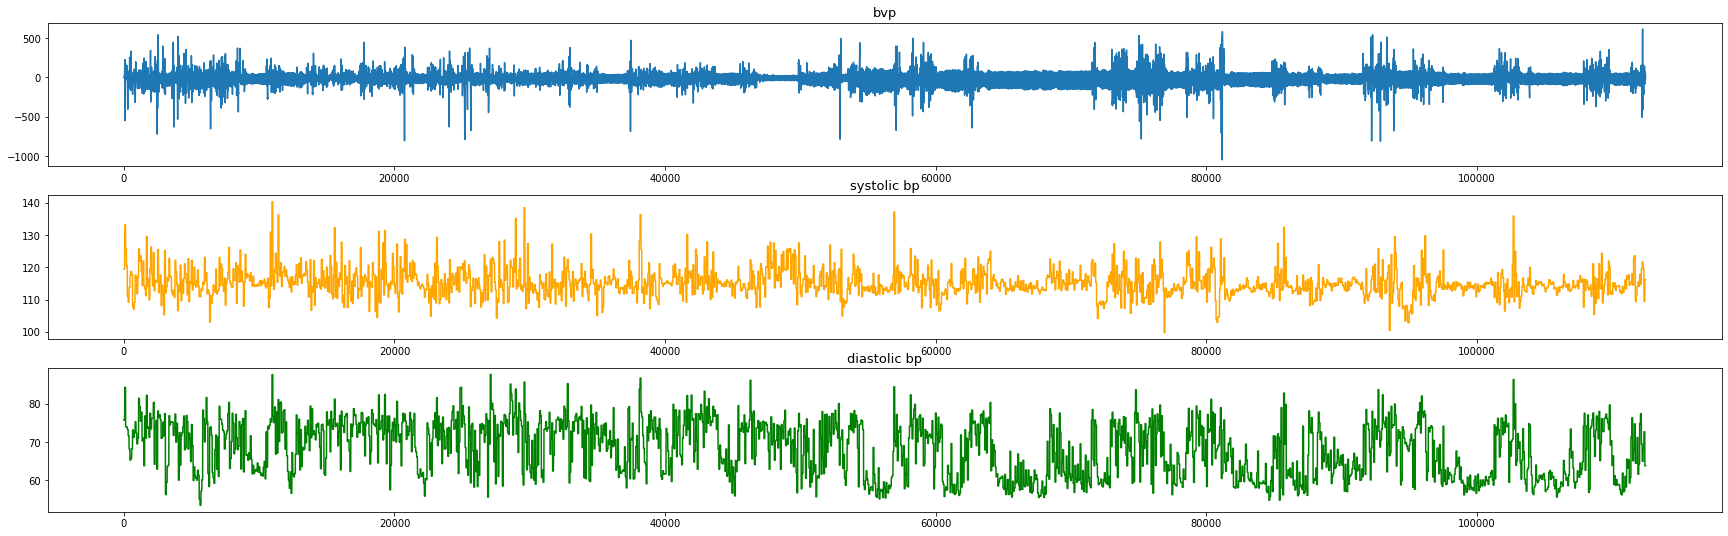

In [8]:
bvp = pd.read_csv(f'{data_path}/BVP.csv')
seq_len = 64
input_data = getInputData(bvp, seq_len)

# model = getModel(model_path)
# bp = getBP(model, input_data)
bp = getBP_oneshot(model_path, input_data)
print(bvp)
print(bp)
plot(bvp, bp, seq_len)
# plot(bvp, bp, seq_len, [1000, 5000])